In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as scp
import scipy.integrate

In [2]:

def l96rhs(xin, tin, pars):
  F = pars
  ndim, = xin.shape
  # index of the current grid point
  k00 = np.arange(ndim)
  # index for the next grid point
  kp1 = np.mod(np.arange(1,ndim+1), ndim)
  # index for the previous grid point
  km1 = np.mod(np.arange(-1,ndim-1), ndim)
  # index for previous to previous grid point
  km2 = np.mod(np.arange(-2,ndim-2), ndim)
  frhs = (xin[kp1] - xin[km2]) * xin[km1] - xin[k00] + F
  return frhs


In [3]:

## find an initial condition on the attractor
ndim =32
F=8.0
pars = (F)

xrand = np.random.rand(ndim)
ttrans = np.linspace(0,100,1000)
xtrans = scp.integrate.odeint(l96rhs, xrand, ttrans, (pars,))

t = np.linspace(0,50,100000)
xattr = xtrans[-1,:]




(10000, 32)


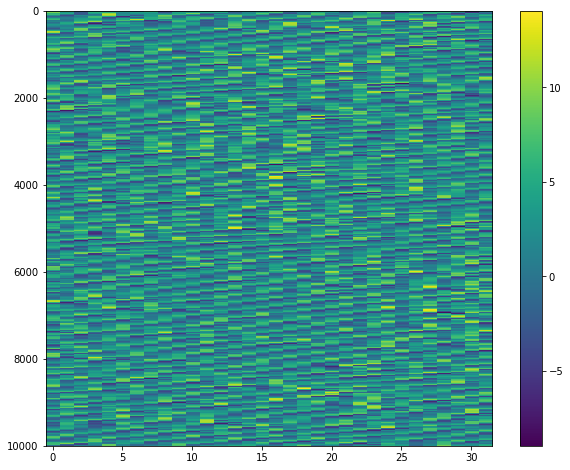

In [4]:

## plot a long trajectory...
tlong = np.linspace(0,100,10000)
xlong = scp.integrate.odeint(l96rhs, xattr, tlong, (pars,))
print(xlong.shape)
plt.figure(figsize=(10, 8))
plt.imshow(xlong, aspect='auto')
plt.colorbar()



# Some "parameters" you may want to change...

nobs --> number of observatoins

deltaobs --> time between consecutive observations

dobs --> dimension of obs, and correspondingly:
H --> linear observation operator
sigmaobs --> observational error std.dev.

sigmainit --> the std.dev. of the initial ensemble

infl --> "inflation" factor for the covariance


In [5]:

#### parameters to change to generate different observations
nobs = 50
deltaobs = 0.1

dobs = 8
H = np.zeros([8,32])
for ii in np.arange(8):
    H[ii,ii*4] = 1.0

sigmaobs = np.abs(np.max(xlong[:,0]) - np.min(xlong[:,0]))/50

sigmainit = sigmaobs*10

infl = 1.0


In [6]:

## generate true trajectory
tend = nobs * deltaobs
tobs = np.linspace(0, tend, num=nobs+1)
ttraj = np.linspace(0, tend, num=nobs*100+1)
truetraj = scp.integrate.odeint(l96rhs, xattr, ttraj, (pars,))
truestate = truetraj[::100,:]

print(truetraj.shape, truestate.shape)

(5001, 32) (51, 32)


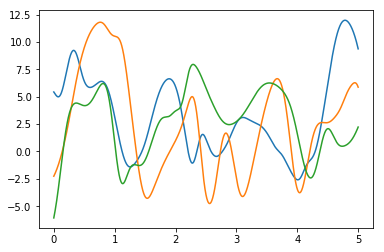

In [7]:

plt.plot(ttraj, truetraj[:,0])
plt.plot(ttraj, truetraj[:,4])
plt.plot(ttraj, truetraj[:,9])


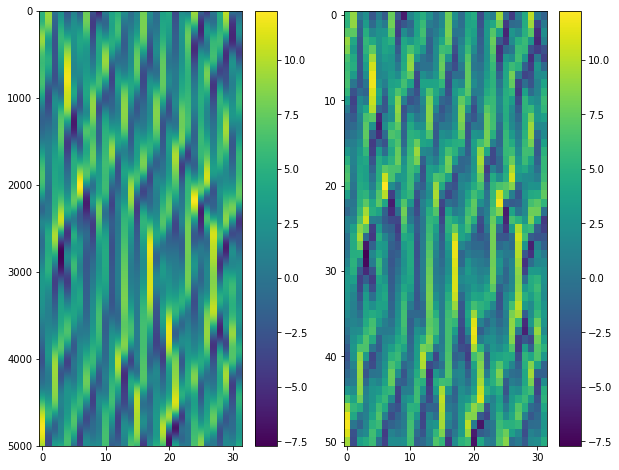

In [8]:

plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.imshow(truetraj, aspect='auto')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(truestate, aspect='auto')
plt.colorbar()


In [9]:

## generate observations

trueobs = H @ truestate.T
robs = sigmaobs*sigmaobs
Robsmat = np.identity(dobs)*robs
yobs = trueobs + np.random.multivariate_normal(np.zeros(dobs), Robsmat,51).T



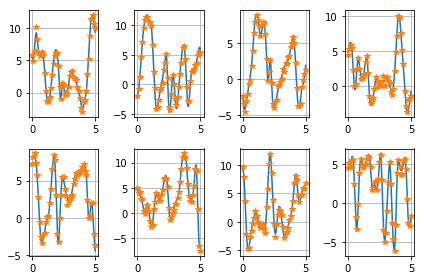

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=4)
for ii, ax in enumerate(axes.flat, start=1):
    ax.plot(ttraj, truetraj[:,(ii-1)*4])
    ax.plot(tobs, yobs[(ii-1),:],'*')
    ax.grid()

fig.tight_layout()


In [11]:


#### example where the ensemble covariance is too small....
sigmainit = sigmaobs*10

infl = 4.0

## now use the observations in EnKF!!
xfm = np.zeros([nobs+1, ndim])
xam = np.zeros([nobs+1, ndim])
xfcov = np.zeros([nobs+1, ndim, ndim])
xacov = np.zeros([nobs+1, ndim, ndim])

## set the initial mean and covariance:
xam[0,:] = xattr + sigmainit*np.random.randn(*xattr.shape)
xacov[0,:,:] = np.identity(ndim)*sigmainit*sigmainit

nens = 100
## Generate initial ensemble
xens = np.random.multivariate_normal(xam[0,:], xacov[0,:,:], nens)
# this is nens,ndim size matrix with the ensemble....
print(xens.shape, np.cov(xens.T).shape, np.mean(xens,axis=0).shape)

## free run ensemble
xnens = np.random.multivariate_normal(xam[0,:], xacov[0,:,:], nens)
xnm = np.zeros([nobs+1, ndim])
xncov = np.zeros([nobs+1, ndim, ndim])

## plt.plot(xens[:,0], xens[:,1],'.'); plt.plot(xattr[0], xattr[1],'*')

for ii in np.arange(nobs):
    ## forecast
    for jj in np.arange(nens):
        xens[jj,:] = scp.integrate.odeint(l96rhs, xens[jj,:], [tobs[ii], tobs[ii+1]], (pars,))[-1,:]
        xnens[jj,:] = scp.integrate.odeint(l96rhs, xnens[jj,:], [tobs[ii], tobs[ii+1]], (pars,))[-1,:]
    ## save forecast mean and cov
    xfm[ii+1,:] = np.mean(xens,axis=0)
    xfcov[ii+1,:,:] = np.cov(xens.T)
    xnm[ii+1,:] = np.mean(xnens,axis=0)
    xncov[ii+1,:,:] = np.cov(xnens.T)
    ## update
    # Kalman gain:
    pf = xfcov[ii+1,:,:]*infl
    pfht = pf @ H.T
    kgain = pfht @ np.linalg.inv( H @ pfht + Robsmat)
    pertobs = np.tile(yobs[:,3+1],(nens,1)).T + np.random.multivariate_normal(np.zeros(dobs), Robsmat,nens).T
    # (np.random.multivariate_normal(np.zeros(dobs),Robsmat,nens).T + np.tile(yobs[:,3+1],(nens,1)).T).shape
    # (dobs, nens)
    for jj in np.arange(nens):
        xens[jj,:] = xens[jj,:] + kgain @ (pertobs[:,jj] - H @ xens[jj,:])
    ## save forecast mean and cov
    xam[ii+1,:] = np.mean(xens,axis=0)
    xacov[ii+1,:,:] = np.cov(xens.T)


(100, 32) (32, 32) (32,)


In [13]:

## some plotting functions
def plotwitherrorbarsobsplt(iob, itr, nsig, frflag):
    lt, = plt.plot(ttraj, truetraj[:,itr])
    lf, = plt.plot(tobs[1:], xfm[1::,itr], '.-')
    la, = plt.plot(tobs, xam[:,itr], '.-')
    ln, = plt.plot(tobs[1:], xnm[1:,itr], '.-')
    errf = np.sqrt(xfcov[:,itr,itr])*nsig
    plt.fill_between(tobs[1:], xfm[1:,itr] - errf[1:], xfm[1:,itr] + errf[1:], alpha=0.5, color = lf.get_color())
    erra = np.sqrt(xacov[:,itr,itr])*nsig
    plt.fill_between(tobs[1:], xam[1:,itr] - erra[1:], xam[1:,itr] + erra[1:], alpha=0.5, color = la.get_color())
    if frflag:
        errn = np.sqrt(xncov[:,itr,itr])*nsig
        plt.fill_between(tobs[1:], xnm[1:,itr] - errn[1:], xnm[1:,itr] + errn[1:], alpha=0.5, color = ln.get_color())
    plt.plot(tobs, yobs[iob,:],'.-')
    erro = np.sqrt(Robsmat[iob,iob])*nsig
    plt.fill_between(tobs[:], truestate[:,itr] - erro, truestate[:,itr]+ erro, alpha=0.5, color = lt.get_color())

def plotwitherrorbarsnoobplt(itr, nsig, frflag):
    lt, = plt.plot(ttraj, truetraj[:,itr])
    lf, = plt.plot(tobs[1:], xfm[1::,itr], '.-')
    la, = plt.plot(tobs, xam[:,itr], '.-')
    ln, = plt.plot(tobs[1:], xnm[1:,itr], '.-')
    errf = np.sqrt(xfcov[:,itr,itr])*nsig
    plt.fill_between(tobs[1:], xfm[1:,itr] - errf[1:], xfm[1:,itr] + errf[1:], alpha=0.5, color = lf.get_color())
    erra = np.sqrt(xacov[:,itr,itr])*nsig
    plt.fill_between(tobs[1:], xam[1:,itr] - erra[1:], xam[1:,itr] + erra[1:], alpha=0.5, color = la.get_color())
    if frflag:
        errn = np.sqrt(xncov[:,itr,itr])*nsig
        plt.fill_between(tobs[1:], xnm[1:,itr] - errn[1:], xnm[1:,itr] + errn[1:], alpha=0.5, color = ln.get_color())
    # plt.plot(tobs, yobs[iob,:],'.-')
    # erro = np.sqrt(Robsmat[iob,iob])*nsig
    # plt.fill_between(tobs[:], truestate[:,itr] - erro, truestate[:,itr]+ erro, alpha=0.5, color = lt.get_color())

def plotwitherrorbarsobsax(iob, itr, nsig, frflag):
    lt, = ax.plot(ttraj, truetraj[:,itr])
    lf, = ax.plot(tobs[1:], xfm[1:,itr], '.-')
    la, = ax.plot(tobs[1:], xam[1:,itr], '.-')
    ln, = ax.plot(tobs[1:], xnm[1:,itr], '.-')
    errf = np.sqrt(xfcov[:,itr,itr])*nsig
    ax.fill_between(tobs[1:], xfm[1:,itr] - errf[1:], xfm[1:,itr] + errf[1:], alpha=0.5, color = lf.get_color())
    erra = np.sqrt(xacov[:,itr,itr])*nsig
    ax.fill_between(tobs[1:], xam[1:,itr] - erra[1:], xam[1:,itr] + erra[1:], alpha=0.5, color = la.get_color())
    if frflag:
        errn = np.sqrt(xncov[:,itr,itr])*nsig
        ax.fill_between(tobs[1:], xnm[1:,itr] - errn[1:], xnm[1:,itr] + errn[1:], alpha=0.5, color = ln.get_color())
    ax.plot(tobs, yobs[iob,:],'.-')
    erro = np.sqrt(Robsmat[iob,iob])*nsig
    ax.fill_between(tobs[1:], truestate[1:,itr] - erro, truestate[1:,itr]+ erro, alpha=0.5, color = lt.get_color())

def plotwitherrorbarsnoobax(itr, nsig, frflag):
    lt, = ax.plot(ttraj, truetraj[:,itr])
    lf, = ax.plot(tobs[1:], xfm[1:,itr], '.-')
    la, = ax.plot(tobs[1:], xam[1:,itr], '.-')
    ln, = ax.plot(tobs[1:], xnm[1:,itr], '.-')
    errf = np.sqrt(xfcov[:,itr,itr])*nsig
    ax.fill_between(tobs[1:], xfm[1:,itr] - errf[1:], xfm[1:,itr] + errf[1:], alpha=0.5, color = lf.get_color())
    erra = np.sqrt(xacov[:,itr,itr])*nsig
    ax.fill_between(tobs[1:], xam[1:,itr] - erra[1:], xam[1:,itr] + erra[1:], alpha=0.5, color = la.get_color())
    if frflag:
        errn = np.sqrt(xncov[:,itr,itr])*nsig
        ax.fill_between(tobs[1:], xnm[1:,itr] - errn, xnm[1:,itr] + errn, alpha=0.5, color = ln.get_color())
    # ax.plot(tobs, yobs[iob,:],'.-')
    # erro = np.sqrt(Robsmat[iob,iob])*nsig
    # ax.fill_between(tobs[1:], truestate[1:,itr] - erro[1:], truestate[1:,itr]+ erro[1:], alpha=0.5, color = lt.get_color())


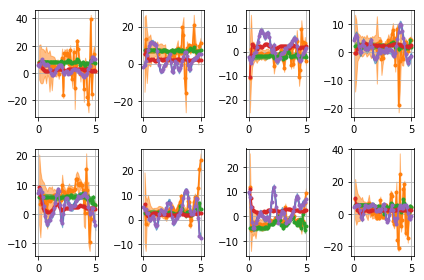

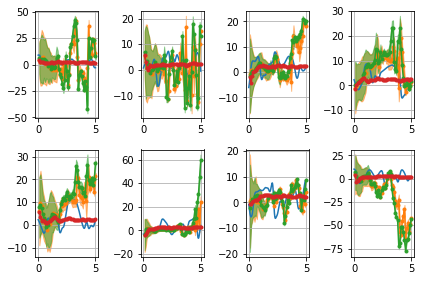

In [14]:

## plot observed variables
frflag=False
nsig=3
fig, axes = plt.subplots(nrows=2, ncols=4)
for ii, ax in enumerate(axes.flat, start=1):
    iob = ii-1
    itr = iob*4
    plotwitherrorbarsobsax(iob, itr, nsig, frflag)
    ax.grid()
fig.tight_layout()

## plot some of the unobserved variables
frflag=False
nsig=3
fig, axes = plt.subplots(nrows=2, ncols=4)
for ii, ax in enumerate(axes.flat, start=1):
    itr = (ii-1)*4+1
    plotwitherrorbarsnoobax(itr, nsig, frflag)
    ax.grid()
fig.tight_layout()


In [27]:

print(truetraj.shape, xfm.shape, xam.shape, xnm.shape)


(5001, 32) (51, 32) (51, 32) (51, 32)


In [28]:

#### example where the ensemble covariance is too small....
sigmainit = sigmaobs*5

infl = 3.0

## now use the observations in EnKF!!
xfm = np.zeros([nobs+1, ndim])
xam = np.zeros([nobs+1, ndim])
xfcov = np.zeros([nobs+1, ndim, ndim])
xacov = np.zeros([nobs+1, ndim, ndim])

## set the initial mean and covariance:
xam[0,:] = xattr + sigmainit*np.random.randn(*xattr.shape)
xacov[0,:,:] = np.identity(ndim)*sigmainit*sigmainit

nens = 100
## Generate initial ensemble
xens = np.random.multivariate_normal(xam[0,:], xacov[0,:,:], nens)
# this is nens,ndim size matrix with the ensemble....
print(xens.shape, np.cov(xens.T).shape, np.mean(xens,axis=0).shape)

## free run ensemble
xnens = xens*1.0 + 0.0
xnm = np.zeros([nobs+1, ndim])
xncov = np.zeros([nobs+1, ndim, ndim])

## plt.plot(xens[:,0], xens[:,1],'.'); plt.plot(xattr[0], xattr[1],'*')

for ii in np.arange(nobs):
    ## forecast
    for jj in np.arange(nens):
        xens[jj,:] = scp.integrate.odeint(l96rhs, xens[jj,:], [tobs[ii], tobs[ii+1]], (pars,))[-1,:]
        xnens[jj,:] = scp.integrate.odeint(l96rhs, xnens[jj,:], [tobs[ii], tobs[ii+1]], (pars,))[-1,:]
    ## save forecast mean and cov
    xfm[ii+1,:] = np.mean(xens,axis=0)
    xfcov[ii+1,:,:] = np.cov(xens.T)
    xnm[ii+1,:] = np.mean(xnens,axis=0)
    xncov[ii+1,:,:] = np.cov(xnens.T)
    ## update
    # Kalman gain:
    pf = xfcov[ii+1,:,:]*infl
    pfht = pf @ H.T
    kgain = pfht @ np.linalg.inv( H @ pfht + Robsmat)
    pertobs = np.tile(yobs[:,3+1],(nens,1)).T + np.random.multivariate_normal(np.zeros(dobs), Robsmat,nens).T
    # (np.random.multivariate_normal(np.zeros(dobs),Robsmat,nens).T + np.tile(yobs[:,3+1],(nens,1)).T).shape
    # (dobs, nens)
    for jj in np.arange(nens):
        xens[jj,:] = xens[jj,:] + kgain @ (pertobs[:,jj] - H @ xens[jj,:])
    ## save forecast mean and cov
    xam[ii+1,:] = np.mean(xens,axis=0)
    xacov[ii+1,:,:] = np.cov(xens.T)


(100, 32) (32, 32) (32,)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


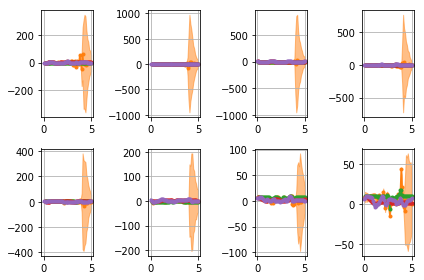

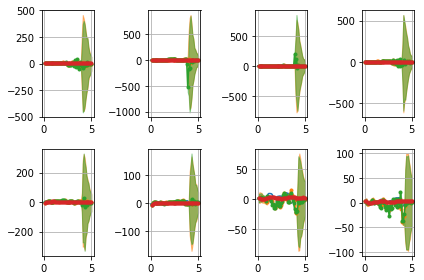

In [29]:

## plot observed variables
frflag=False
nsig=3
fig, axes = plt.subplots(nrows=2, ncols=4)
for ii, ax in enumerate(axes.flat, start=1):
    iob = ii-1
    itr = iob*4
    plotwitherrorbarsobsax(iob, itr, nsig, frflag)
    ax.grid()
fig.tight_layout()

## plot some of the unobserved variables
frflag=False
nsig=3
fig, axes = plt.subplots(nrows=2, ncols=4)
for ii, ax in enumerate(axes.flat, start=1):
    itr = (ii-1)*4+1
    plotwitherrorbarsnoobax(itr, nsig, frflag)
    ax.grid()
fig.tight_layout()


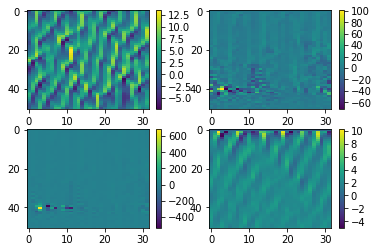

In [30]:

plt.subplot(2,2,1)
plt.imshow(truestate, aspect='auto')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(xfm, aspect='auto')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(xam, aspect='auto')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(xnm, aspect='auto')
plt.colorbar()



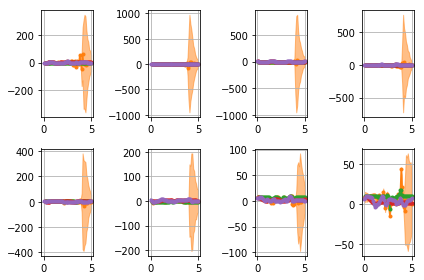

In [31]:

## plot observed variables
frflag=False
nsig=3
fig, axes = plt.subplots(nrows=2, ncols=4)
for ii, ax in enumerate(axes.flat, start=1):
    iob = ii-1
    itr = iob*4
    plotwitherrorbarsobsax(iob, itr, nsig, frflag)
    ax.grid()
fig.tight_layout()


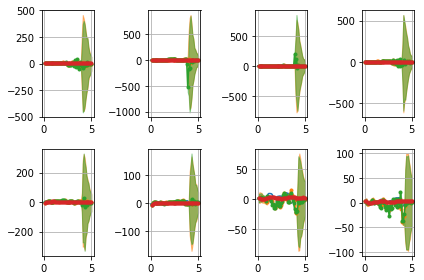

In [32]:

## plot some of the unobserved variables
frflag=False
nsig=3
fig, axes = plt.subplots(nrows=2, ncols=4)
for ii, ax in enumerate(axes.flat, start=1):
    itr = (ii-1)*4+1
    plotwitherrorbarsnoobax(itr, nsig, frflag)
    ax.grid()
fig.tight_layout()


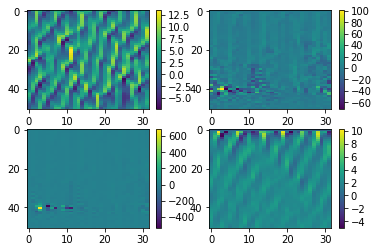

In [33]:

plt.subplot(2,2,1)
plt.imshow(truestate, aspect='auto')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(xfm, aspect='auto')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(xam, aspect='auto')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(xnm, aspect='auto')
plt.colorbar()


In [34]:

### one way to generate tridiagonal positive definite matrix
ndim=5
dg = np.random.rand(ndim) + 1.0
udg = np.random.rand(ndim-1)
cmat = np.diag(dg) + np.diag(udg,1)
# print(cmat)
pp = cmat @ cmat.T
# print(pp)
evp, egp = np.linalg.eig(pp)
print(evp, egp)


[4.93113261 3.38391888 0.46641528 2.09359571 1.28469686] [[ 0.19401751 -0.34325623  0.49039758  0.72308293 -0.28494502]
 [ 0.54925574 -0.47647109 -0.65352957  0.13361789  0.16229235]
 [ 0.68776945 -0.02506521  0.5069932  -0.51494404  0.06430748]
 [ 0.42367069  0.75201575 -0.23172725  0.25501271 -0.36911579]
 [ 0.09028661  0.29831949  0.14720632  0.35930279  0.8672287 ]]


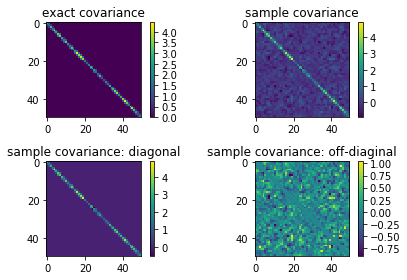

In [35]:


#### -- -- -- An experiment
## if we sample a triadiagonal matrix
## and then compare the exact covariance with the sample covariance
## we see the "spurious" off-diaginal entries
#### -- -- -- -- -- --

ndim = 50
dg = np.random.rand(ndim) + 1.0
udg = np.random.rand(ndim-1)
cmat = np.diag(dg) + np.diag(udg,1)
pp = cmat @ cmat.T
mn = np.zeros(ndim)
nens = 100

xsamp = np.random.multivariate_normal(mn, pp, nens).T
xcov = np.cov(xsamp)
xcovu = np.triu(xcov,2)
xcovl = np.tril(xcov,-2)
xcovd3 = xcov - xcovu - xcovl
xcovoffd = xcovu + xcovl

plt.subplot(2,2,1)
plt.imshow(pp)
plt.colorbar(); plt.title('exact covariance')
plt.subplot(2,2,2)
plt.imshow(xcov)
plt.colorbar(); plt.title('sample covariance')
plt.subplot(2,2,3)
plt.imshow(xcovd3)
plt.colorbar(); plt.title('sample covariance: diagonal')
plt.subplot(2,2,4)
plt.imshow(xcovoffd)
plt.colorbar(); plt.title('sample covariance: off-diaginal')
plt.tight_layout()


(51, 32) (51, 32)


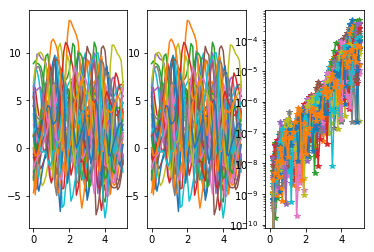

In [36]:


#### -- -- -- An experiment
## if we integrate the equations over a time period
## and then compare this to integrating over shorter time intervals
## what happens for chaotic systems???
#### -- -- -- -- -- --

tob = np.linspace(0, tend, num=nobs+1)
xtt = scp.integrate.odeint(l96rhs, xattr, tobs, (pars,))
x1 = xtt*0.0
x1[0,:] = xattr
for ii in np.arange(nobs):
    x1[ii+1,:] = scp.integrate.odeint(l96rhs, x1[ii,:], [tob[ii], tob[ii+1]], (pars,))[-1,:]
print(xtt.shape, x1.shape)

plt.subplot(1,3,1)
plt.plot(tob,xtt)
plt.subplot(1,3,2)
plt.plot(tob,x1)
plt.subplot(1,3,3)
plt.semilogy(tob,np.abs(xtt-x1),'-*')


In [37]:

pp=np.random.rand(4,4)+1
pp = pp @ pp.T
qq=pp*2
print(np.linalg.eig(pp))
print(np.linalg.eig(qq))


(array([3.48907174e+01, 1.20165002e-01, 5.78177922e-03, 5.54948581e-01]), array([[ 0.53640043,  0.83019293, -0.15111531,  0.01477975],
       [ 0.5391927 , -0.21931034,  0.74168056,  0.3332929 ],
       [ 0.46249066, -0.29253917, -0.04721108, -0.83564008],
       [ 0.45568433, -0.42083668, -0.65180152,  0.43635199]]))
(array([6.97814348e+01, 2.40330005e-01, 1.15635584e-02, 1.10989716e+00]), array([[ 0.53640043,  0.83019293, -0.15111531,  0.01477975],
       [ 0.5391927 , -0.21931034,  0.74168056,  0.3332929 ],
       [ 0.46249066, -0.29253917, -0.04721108, -0.83564008],
       [ 0.45568433, -0.42083668, -0.65180152,  0.43635199]]))
